In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Tue Aug  2 16:47:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 73%   83C    P2   167W / 260W |   5747MiB / 11019MiB |     93%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 32%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_cn = db.rm_patent_cn
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2017 = db.rm_patent_us_2017
    db_rm_cn_2017 = db.rm_patent_cn_2017
    # db_rm_de_2017 = db.rm_patent_de_2017
except errors.ConnectionFailure as err:
    print(err)

# 2017

## Company數量

In [6]:
data_assignee = db_rm_cn_2017.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [7]:
# 取總數前15家公司
# final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
df_family_cn.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(16)

,company,count
22,Shenzhen Shenglu IoT Communication Technology ...,622
13,Huawei Technologies Co Ltd,268
19,Samsung Electronics Co Ltd,204
18,Qualcomm Inc,203
26,Xian Irain IoT Technology Service Co Ltd,139
2,Chengdu Qinchuan IoT Technology Co Ltd,117
11,Hangzhou Wopu IoT Technology Co Ltd,110
4,China Mobile Communications Group Co Ltd,91
27,ZTE Corp,83
20,Shanghai Langbo Communication Technology Co Ltd,73


In [8]:
# com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df = df_family_cn.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [9]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Shenzhen Shenglu IoT Communication Technology ...,622,6.432940
1,Huawei Technologies Co Ltd,268,5.590987
2,Samsung Electronics Co Ltd,204,5.318120
3,Qualcomm Inc,203,5.313206
4,Xian Irain IoT Technology Service Co Ltd,139,4.934474
5,Chengdu Qinchuan IoT Technology Co Ltd,117,4.762174
6,Hangzhou Wopu IoT Technology Co Ltd,110,4.700480
7,China Mobile Communications Group Co Ltd,91,4.510860
8,ZTE Corp,83,4.418841
9,Shanghai Langbo Communication Technology Co Ltd,73,4.290459


In [10]:
com_ls = list(com_df.company)

## Data

In [11]:
ccontry = pd.read_csv("../patent/code/依年分/rm_company_country_cn_2017.csv")
ccpc = pd.read_csv("../LDA/company_lda_brief_cn_2017.csv")

In [12]:
ccontry[ccontry.company.isin(com_ls)]

,company,AR,AU,BE,BR,CA,CH,CL,CN,CO,...,PL,PT,RU,SE,SG,SI,TR,TW,US,ZA
244,Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,China Mobile Communications Group Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
469,Fujian Strong Min Mdt Infotech Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
621,HUIZHOU TECHZEN IOT SCIENCE & TECHNOLOGY Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
660,Hangzhou Wopu IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
739,Huaway IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
743,Huawei Technologies Co Ltd,1.0,11.0,0.0,40.0,12.0,0.0,0.0,268.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,132.0,1.0
804,Intel Corp,0.0,0.0,0.0,2.0,0.0,0.0,0.0,46.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,31.0,0.0
1147,Qualcomm Inc,1.0,59.0,0.0,94.0,48.0,0.0,2.0,198.0,2.0,...,0.0,0.0,3.0,0.0,18.0,2.0,0.0,54.0,195.0,1.0
1234,Samsung Electronics Co Ltd,0.0,9.0,0.0,1.0,2.0,0.0,0.0,272.0,0.0,...,2.0,1.0,3.0,0.0,0.0,0.0,0.0,2.0,179.0,0.0


## Similarity計算

### Country

- 換成機率  

In [13]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [14]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AR,AU,BE,BR,CA,CH,CL,CN,CO,CR,...,PL,PT,RU,SE,SG,SI,TR,TW,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Shenzhen Shenglu IoT Communication Technology Co Ltd,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
Huawei Technologies Co Ltd,0.001445,0.015896,0.0,0.057803,0.017341,0.0,0.000000,0.387283,0.000000,0.0,...,0.00000,0.000000,0.010116,0.0,0.000000,0.000000,0.0,0.000000,0.190751,0.001445
Samsung Electronics Co Ltd,0.000000,0.010576,0.0,0.001175,0.002350,0.0,0.000000,0.319624,0.000000,0.0,...,0.00235,0.001175,0.003525,0.0,0.000000,0.000000,0.0,0.002350,0.210341,0.000000
Qualcomm Inc,0.000994,0.058648,0.0,0.093439,0.047714,0.0,0.001988,0.196819,0.001988,0.0,...,0.00000,0.000000,0.002982,0.0,0.017893,0.001988,0.0,0.053678,0.193837,0.000994
Xian Irain IoT Technology Service Co Ltd,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [15]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [16]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [17]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [18]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [19]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

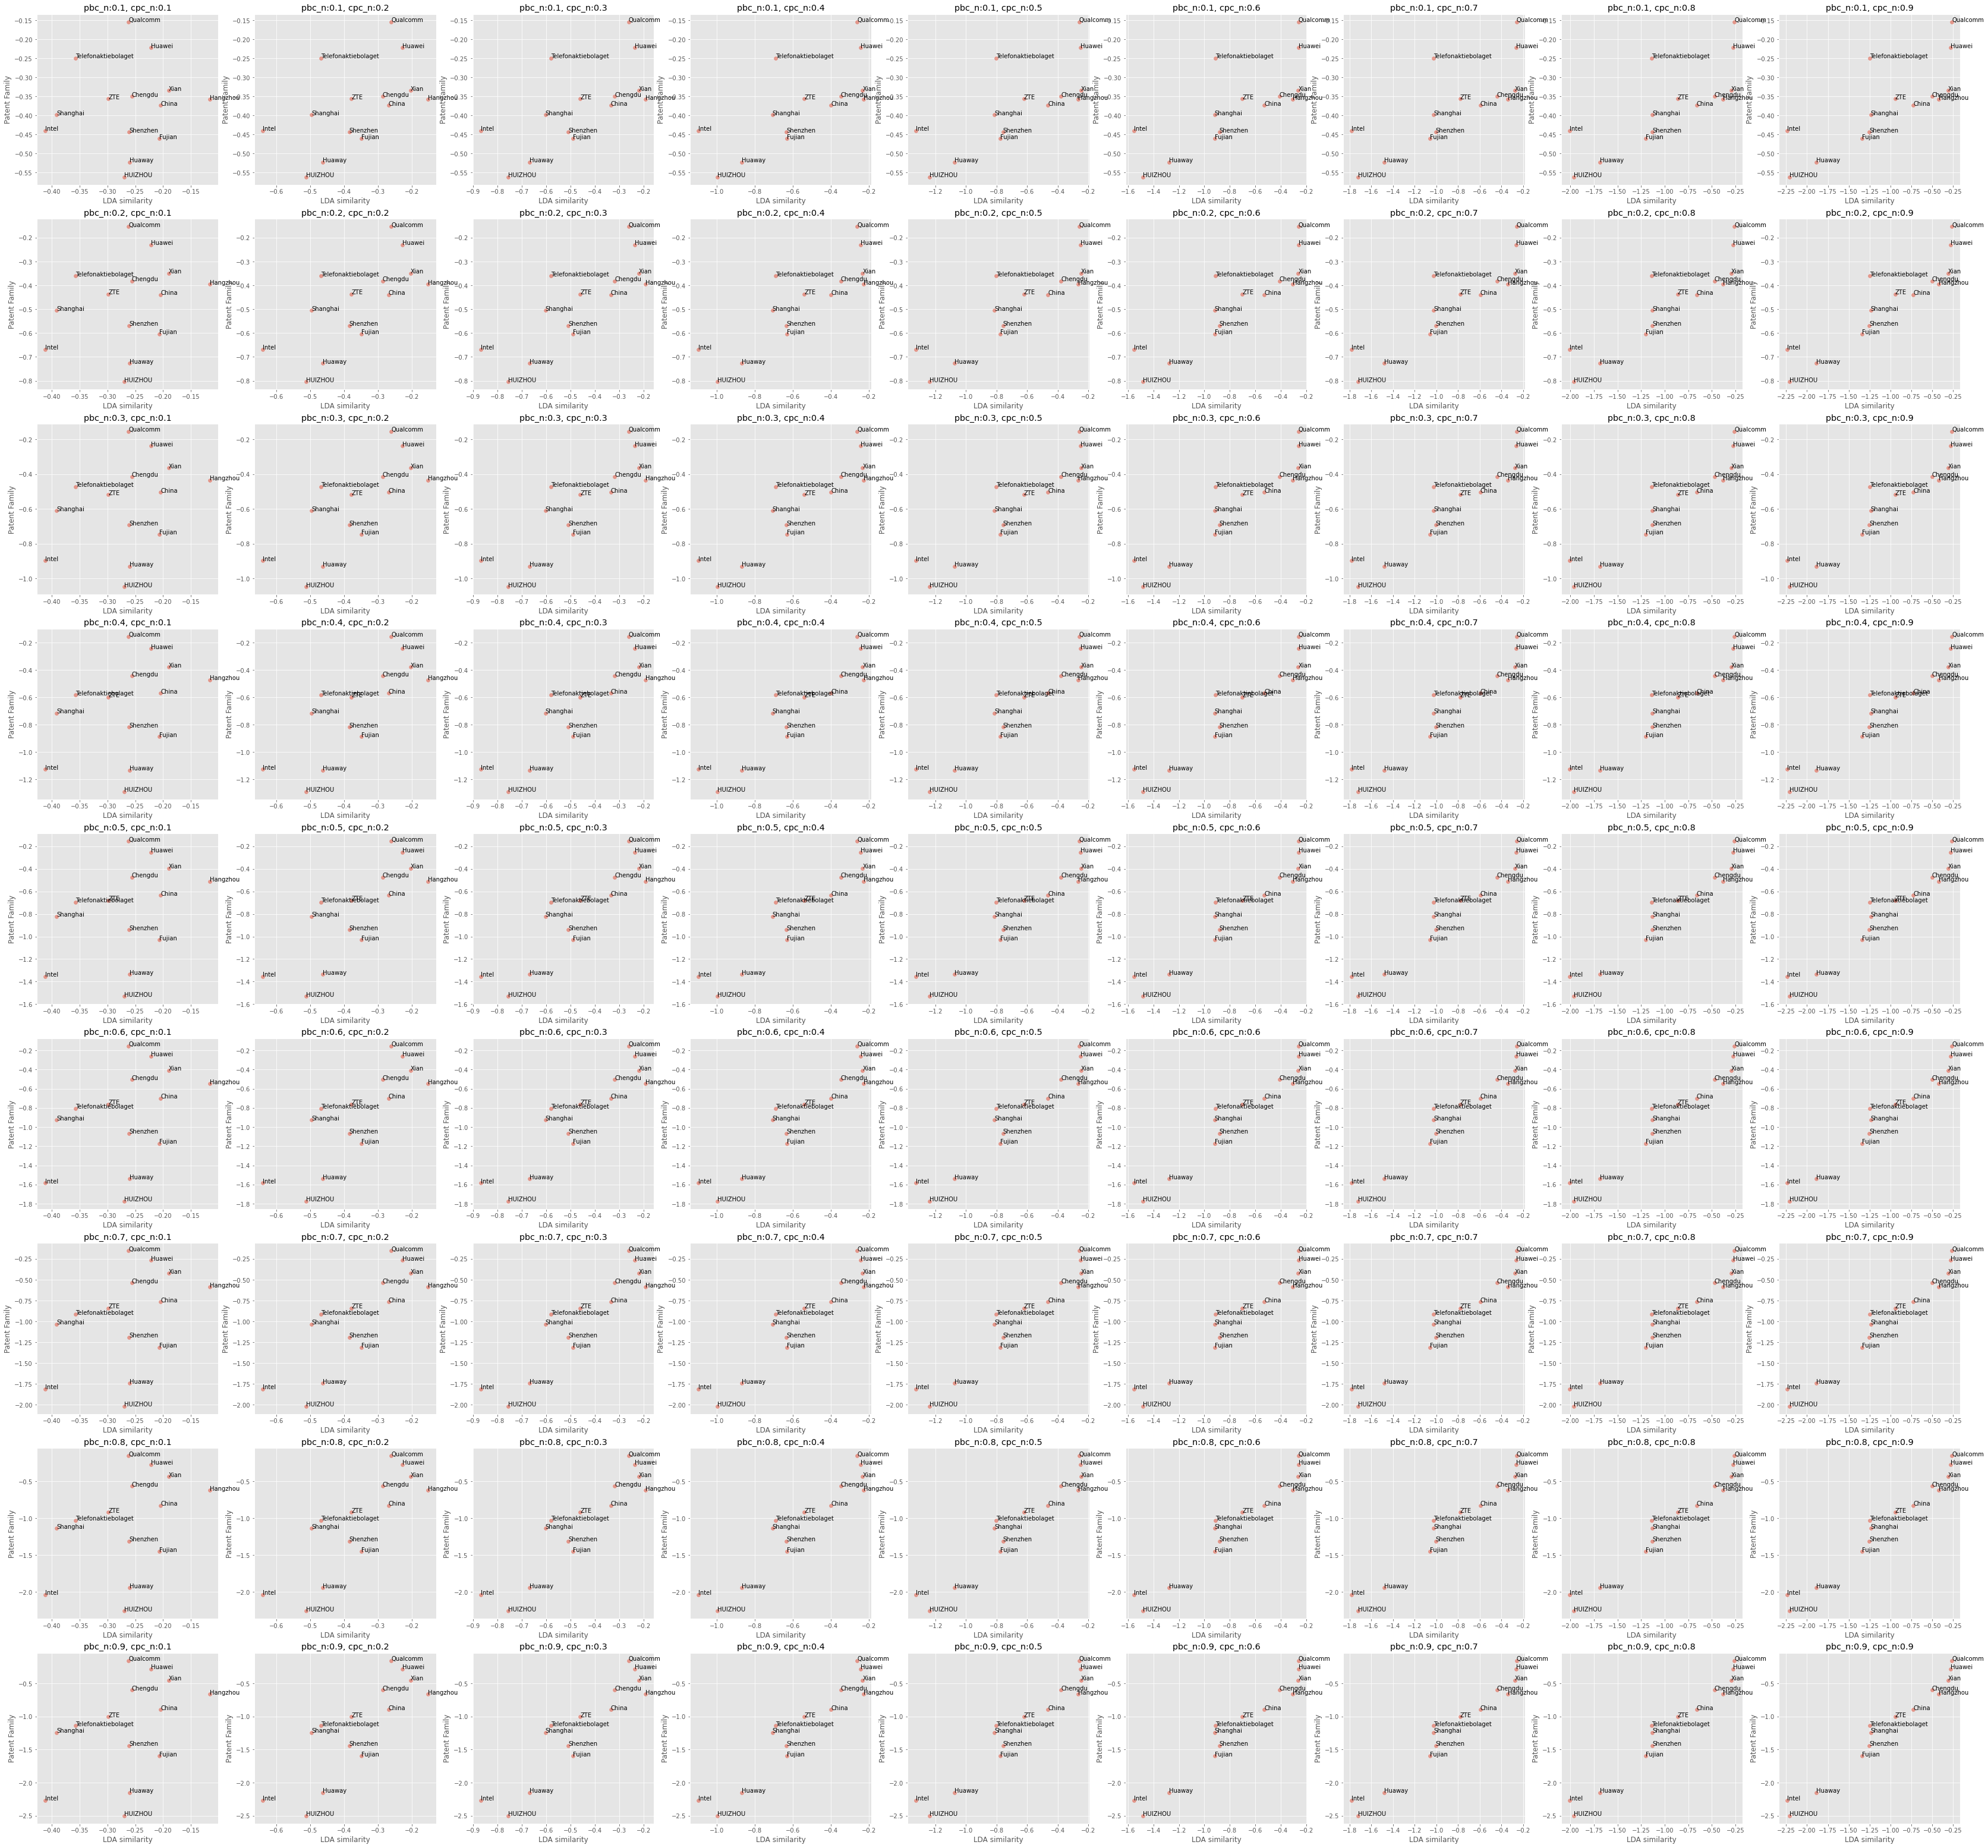

In [20]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("LDA similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_cn_brief_2017_1.png'.format(pbc_n))

In [21]:
c_df

,cpc,country
company,,
Shenzhen Shenglu IoT Communication Technology Co Ltd,1.255324,1.438165
Huawei Technologies Co Ltd,0.280886,0.281276
Qualcomm Inc,0.261902,0.153877
Xian Irain IoT Technology Service Co Ltd,0.307526,0.452090
Chengdu Qinchuan IoT Technology Co Ltd,0.503491,0.597792
Hangzhou Wopu IoT Technology Co Ltd,0.421005,0.662955
China Mobile Communications Group Co Ltd,0.725966,0.894996
ZTE Corp,0.944996,1.003080
Shanghai Langbo Communication Technology Co Ltd,1.236067,1.243591


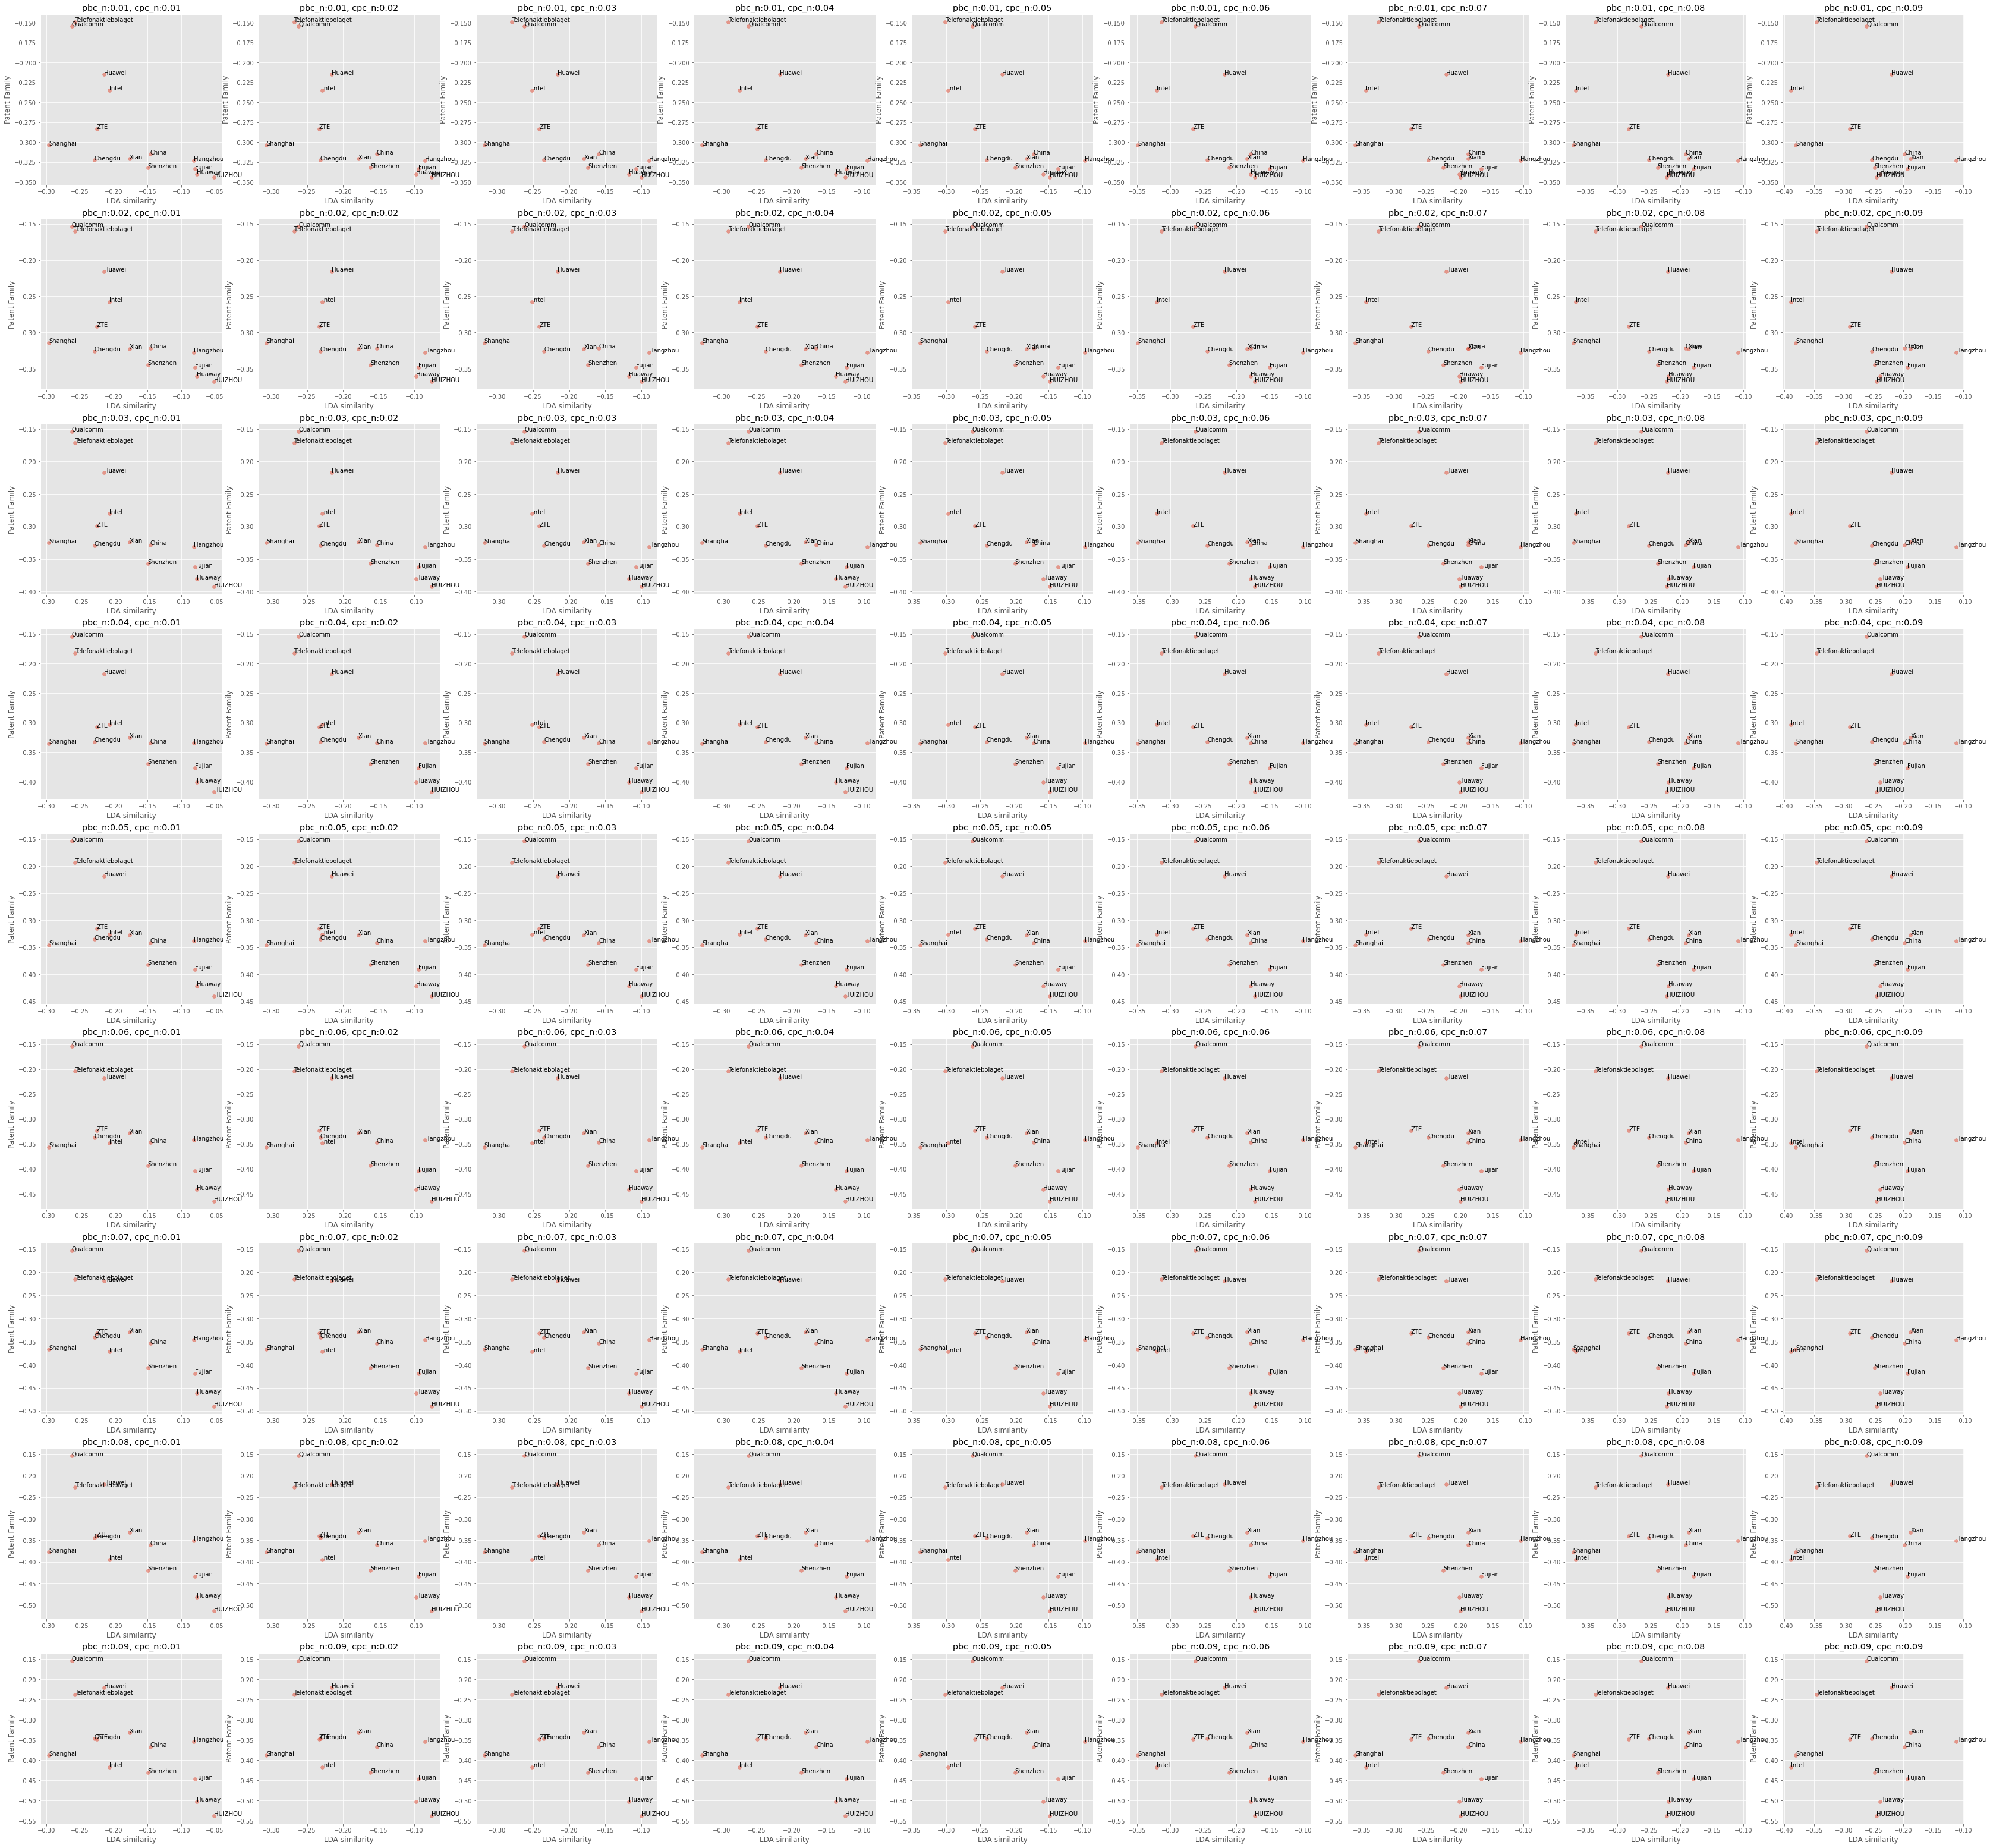

In [22]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("LDA similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_cn_brief_2017_2.png'.format(pbc_n))

In [23]:
c_df

,cpc,country
company,,
Shenzhen Shenglu IoT Communication Technology Co Ltd,0.248636,0.431478
Huawei Technologies Co Ltd,0.220577,0.220966
Qualcomm Inc,0.261883,0.153857
Xian Irain IoT Technology Service Co Ltd,0.188307,0.332871
Chengdu Qinchuan IoT Technology Co Ltd,0.253139,0.347441
Hangzhou Wopu IoT Technology Co Ltd,0.112007,0.353957
China Mobile Communications Group Co Ltd,0.198114,0.367144
ZTE Corp,0.289946,0.348030
Shanghai Langbo Communication Technology Co Ltd,0.380637,0.388161


In [24]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia")\
                                                    .replace("China Mobile","China_Mobile")\
                                                    .replace("China Mobile IoT","China_Mobile_IoT")\
                                                    .replace("China United Network Communications Group","China_Unicom")\
                                                    .replace("Shanghai Langbo Communication Technology","Shanghai_Langbo")\
                                                    .replace("State Grid of China SGCC","SGCC")\
                                                    .replace("Beijing Sankuai Online Technology","Beijing_Sankuai")\
                                                    .replace("Beijing Xiaomi Mobile Software","Xiaomi")\
                                                    .replace("Guangdong Oppo Mobile Telecommunications","Oppo")\
                                                    .replace("Shanghai Roye Electric Science and Technology","Shanghai_Roye_Electric")\
                                                    .replace("Xian Irain IoT Technology Servic","Xian_Irain")\
                                                    .replace("China University of Geosciences","CUG")\
                                                    .replace("Shenzhen Shenglu IoT Communication Technology","Shenglu")\
                                                    .replace("Chengdu Qinchuan IoT Technology","Qinchuan_IoT")\
                                                    .replace("Hangzhou Wopu IoT Technology","Wopu_IoT")\
                                                    .replace("Huaway IoT Technology","Huaway_IoT")\
                                                    .replace("HUIZHOU TECHZEN IOT SCIENCE & TECHNOLOGY","HUIZHOU_TECHZEN_IOT"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

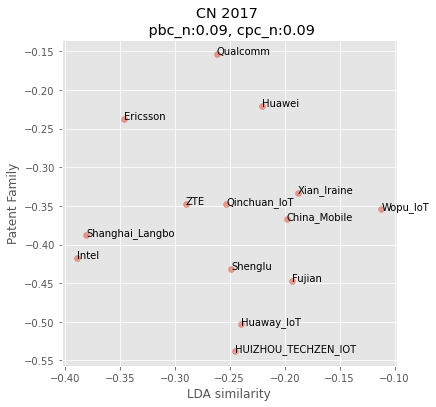

In [25]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("CN 2017 \n pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("LDA similarity")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [26]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [27]:
competitor_ls

[3, 1, 2, 1, 4, 3, 3, 4, 4, 2, 3, 3, 4, 3]

In [28]:
c_df

,cpc,country
company,,
Shenglu,0.248636,0.431478
Huawei Technologies,0.220577,0.220966
Qualcomm,0.261883,0.153857
Xian_Iraine,0.188307,0.332871
Qinchuan_IoT,0.253139,0.347441
Wopu_IoT,0.112007,0.353957
China_Mobile,0.198114,0.367144
ZTE,0.289946,0.348030
Shanghai_Langbo,0.380637,0.388161


In [29]:
c_df.to_csv("competitor_df/company/lda_cn_2017.csv")